#  Hate Speech Detection 

Installing Huggingface package:

In [2]:
 !pip install transformers datasets
 !pip install evaluate transformers[sentencepiece]
 !pip install accelerate

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.9 MB 2.1 MB/s 
     |████████████████████████████████| 431 kB 51.2 MB/s 
     |████████████████████████████████| 6.6 MB 3.7 MB/s 
     |████████████████████████████████| 163 kB 100.4 MB/s 
     |████████████████████████████████| 212 kB 85.4 MB/s 
     |████████████████████████████████| 115 kB 77.7 MB/s 
     |████████████████████████████████| 127 kB 89.8 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 69 kB 1.7 MB/s 
     |████████████████████████████████| 1.3 MB 4.3 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████

In [3]:
from datasets import load_dataset, DatasetDict
from transformers import AutoTokenizer, DataCollatorWithPadding

raw_dataset = load_dataset("hate_speech_offensive", split= "train")
# Dataset is already shuffled very well!

# this dataset only has train dict , I am trying to split it into train,validation and test
train_testvalid = raw_dataset.train_test_split(test_size=0.2)
test_valid = train_testvalid['test'].train_test_split(test_size=0.5)
, and test
train_testvalid = raw_dataset.train_test_split(test_size=0.2)
test_valid = train_testvalid['test'].train_test_split(test_size=0.5)
train_test_valid_dataset = DatasetDict({
    'train': train_testvalid['train'],
    'test': test_valid['test'],
    'validation': test_valid['train']})
train_test_valid_dataset
#train_testvalid

/usr/local/lib/python3.7/dist-packages/huggingface_hub/utils/_deprecation.py:97: FutureWarning: Deprecated argument(s) used in 'dataset_info': token. Will not be supported from version '0.12'.
  warnings.warn(message, FutureWarning)


Generating train split:   0%|          | 0/24783 [00:00<?, ? examples/s]

Dataset hate_speech_offensive downloaded and prepared to /root/.cache/huggingface/datasets/hate_speech_offensive/default/1.0.0/5f5dfc7b42b5c650fe30a8c49df90b7dbb9c7a4b3fe43ae2e66fabfea35113f5. Subsequent calls will reuse this data.


DatasetDict({
    train: Dataset({
        features: ['count', 'hate_speech_count', 'offensive_language_count', 'neither_count', 'class', 'tweet'],
        num_rows: 19826
    })
    test: Dataset({
        features: ['count', 'hate_speech_count', 'offensive_language_count', 'neither_count', 'class', 'tweet'],
        num_rows: 2479
    })
    validation: Dataset({
        features: ['count', 'hate_speech_count', 'offensive_language_count', 'neither_count', 'class', 'tweet'],
        num_rows: 2478
    })
})

In [4]:

#raw_dataset["train"][13]

checkpoint = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

def tokenize_function(example):
    return tokenizer(example["tweet"], truncation=True) # which part of dataset to tokenize


tokenized_datasets = train_test_valid_dataset.map(tokenize_function, batched=True)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
tokenized_datasets
#tokenized_datasets["train"].column_names

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

  0%|          | 0/20 [00:00<?, ?ba/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

DatasetDict({
    train: Dataset({
        features: ['count', 'hate_speech_count', 'offensive_language_count', 'neither_count', 'class', 'tweet', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 19826
    })
    test: Dataset({
        features: ['count', 'hate_speech_count', 'offensive_language_count', 'neither_count', 'class', 'tweet', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 2479
    })
    validation: Dataset({
        features: ['count', 'hate_speech_count', 'offensive_language_count', 'neither_count', 'class', 'tweet', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 2478
    })
})

In [5]:
tokenized_datasets = tokenized_datasets.remove_columns([ "count", "hate_speech_count", "offensive_language_count", "neither_count", "tweet"])
tokenized_datasets = tokenized_datasets.rename_column("class", "labels")
tokenized_datasets.set_format("torch")
tokenized_datasets["train"].column_names


['labels', 'input_ids', 'token_type_ids', 'attention_mask']

In [6]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(
    tokenized_datasets["train"], batch_size=8, collate_fn=data_collator
)
eval_dataloader = DataLoader(
    tokenized_datasets["validation"], batch_size=8, collate_fn=data_collator
)


In [7]:
for batch in train_dataloader:
    break
{k: v.shape for k, v in batch.items()}

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


{'labels': torch.Size([8]),
 'input_ids': torch.Size([8, 46]),
 'token_type_ids': torch.Size([8, 46]),
 'attention_mask': torch.Size([8, 46])}

In [8]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=3)

Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [9]:
outputs = model(**batch)
print(outputs.loss, outputs.logits.shape)

tensor(0.9653, grad_fn=<NllLossBackward0>) torch.Size([8, 3])


In [10]:
from transformers import AdamW
from accelerate import Accelerator

optimizer = AdamW(model.parameters(), lr=1e-5)
accelerator = Accelerator()

train_dl, eval_dl, model, optimizer = accelerator.prepare(
    train_dataloader, eval_dataloader, model, optimizer
)

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [12]:
from transformers import get_scheduler

num_epochs = 30
num_training_steps = num_epochs * len(train_dataloader)
lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps,
)
print(num_training_steps)

74370


In [13]:
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import numpy as np
import torch

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)

progress_bar = tqdm(range(num_training_steps))
loss_list = []
model.train()
for epoch in range(num_epochs):
    for batch in train_dataloader:
        epoch_loss = []
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        #print(loss)
        epoch_loss.append(loss)
        accelerator.backward(loss)

        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)
    loss_list.append(sum(epoch_loss)/len(epoch_loss))
    print(loss_list)


  0%|          | 0/74370 [00:00<?, ?it/s]

[tensor(0.0642, device='cuda:0', grad_fn=<DivBackward0>)]
[tensor(0.0642, device='cuda:0', grad_fn=<DivBackward0>), tensor(0.0118, device='cuda:0', grad_fn=<DivBackward0>)]
[tensor(0.0642, device='cuda:0', grad_fn=<DivBackward0>), tensor(0.0118, device='cuda:0', grad_fn=<DivBackward0>), tensor(0.0137, device='cuda:0', grad_fn=<DivBackward0>)]
[tensor(0.0642, device='cuda:0', grad_fn=<DivBackward0>), tensor(0.0118, device='cuda:0', grad_fn=<DivBackward0>), tensor(0.0137, device='cuda:0', grad_fn=<DivBackward0>), tensor(0.0110, device='cuda:0', grad_fn=<DivBackward0>)]
[tensor(0.0642, device='cuda:0', grad_fn=<DivBackward0>), tensor(0.0118, device='cuda:0', grad_fn=<DivBackward0>), tensor(0.0137, device='cuda:0', grad_fn=<DivBackward0>), tensor(0.0110, device='cuda:0', grad_fn=<DivBackward0>), tensor(0.0030, device='cuda:0', grad_fn=<DivBackward0>)]
[tensor(0.0642, device='cuda:0', grad_fn=<DivBackward0>), tensor(0.0118, device='cuda:0', grad_fn=<DivBackward0>), tensor(0.0137, device='cu

0.0641961544752121
0.011848092079162598
0.013708099722862244
0.011018938384950161
0.0030289501883089542
0.005234581883996725
0.0015184347284957767
0.0015991178806871176
0.00040266476571559906
0.0008303179056383669
0.00011854659533128142
8.266750955954194e-05
0.00016514981689397246
8.33237572805956e-05
6.6099084506277e-05
8.469446038361639e-05
3.909983570338227e-05
3.7013625842519104e-05
5.346359102986753e-05
2.7775375201599672e-05
3.5165918234270066e-05
7.408430974464864e-05
2.5152818125206977e-05
2.0861392840743065e-05
3.141113120364025e-05
2.1278583517414518e-05
2.2709069526172243e-05
1.627187702979427e-05
1.353015613858588e-05
3.236468182876706e-05


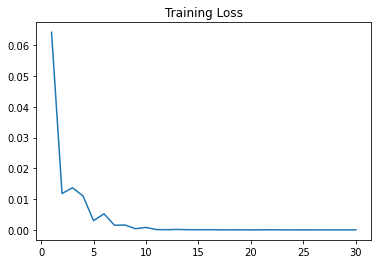

In [14]:
# Drawing leaning curve 
diagram = []
for i in loss_list:
  print(i.item())
  it = i.item()
  diagram.append(it)
diagram

plt.title("Training Loss")
plt.plot(np.linspace(1, num_epochs, num_epochs).astype(int), diagram)

**Evaluating the validation set:**

In [15]:
model.save_pretrained("Documents/my-hate-speech-model")


In [43]:
import evaluate
import torch

# evaluate.combine wasn't working well instead I called the metrics individually
metric = evaluate.load('accuracy') # accuracy, precision, f1

model.eval()
for batch in eval_dataloader:
    batch = {k: v.to(device) for k, v in batch.items()}
    with torch.no_grad():
        outputs = model(**batch)

    logits = outputs.logits
    predictions = torch.argmax(logits, dim=-1)
    metric.add_batch(predictions=predictions, references=batch['labels'])
metric.compute() # call this one for accuracy
#metric.compute(average='weighted') # call this one for f1 and precision


{'accuracy': 0.9071832122679581}

**Evaluating the test set:**

In [44]:
test_dataloader = DataLoader(
    tokenized_datasets["test"], batch_size=8, collate_fn=data_collator
)

In [271]:
metric = evaluate.load('f1')
model.eval()
for batch in test_dataloader:
    batch = {k: v.to(device) for k, v in batch.items()}
    with torch.no_grad():
        outputs = model(**batch)

    logits = outputs.logits
    predictions = torch.argmax(logits, dim=-1)
    metric.add_batch(predictions=predictions, references=batch["labels"])

#metric.compute() # call this one for accuracy
metric.compute(average='weighted') # call this one for f1 and precision

{'f1': 0.9124427497944527}

In [52]:
# Hyperparameters of the model
model.get_output_embeddings

<bound method PreTrainedModel.get_output_embeddings of BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
        

Showing an example were predicted label is different than the label:

In [610]:
train_test_valid_dataset["test"][1727]

{'count': 3,
 'hate_speech_count': 0,
 'offensive_language_count': 2,
 'neither_count': 1,
 'class': 1,
 'tweet': "@amck73 And because it sounds like there is NO prenup, he's gonna cash in, not her. He apparently has ghetto credit. 'magine that?!"}

In [612]:
from transformers import AutoModelForSequenceClassification
from torch import nn

pt_batch = tokenizer(
     ['@amck73 And because it sounds like there is NO prenup, he\'s gonna cash in, not her. He apparently has ghetto credit. \'magine that?!'],
     padding=True,
     truncation=True,
     max_length=512,
     return_tensors="pt",
 )

test_outputs = model(**pt_batch.to(device))

# 0=hate speech, 1=offensive, 2=neither
pt_predictions = nn.functional.softmax(test_outputs.logits, dim=-1)
p = pt_predictions.tolist()
a = []
for i in p:
  a.append(np.argmax(i))
#a = np.argmax(p[1])
a


[2]